In [1]:
import os
os.chdir('9444')
!pwd

FileNotFoundError: [WinError 2] 系统找不到指定的文件。: '9444'

# Define custom class VQADataset

In [2]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""
    def __init__(self, dataset_load, processor_load):
        self.dataset = dataset_load
        self.processor = processor_load

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        question = self.dataset[idx]['question']
        answer = self.dataset[idx]['answer']
        image_id = self.dataset[idx]['image_id']
        image_files_dir = os.path.join('Dataset', 'val2014')
        image_name = 'COCO_val2014_' + '0' * (12 - len(str(image_id))) + str(image_id) + '.jpg'
        image_path = os.path.join(image_files_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        text = question

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
        labels = self.processor.tokenizer.encode(
            answer,
            max_length= 8,
            truncation=True,
            padding="max_length",
            return_tensors='pt',
            return_attention_mask=True
        )
        encoding["labels"] = labels
        encoding["attention_mask"] = encoding["attention_mask"].squeeze()
        # remove batch dimension
        for k,v in encoding.items():  encoding[k] = v.squeeze()
        return encoding

# Load base model

In [3]:
from transformers import BlipProcessor, BlipForQuestionAnswering

cached_dir = os.path.join('BLIP_checkpoints')
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir=cached_dir)
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir=cached_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

torch.manual_seed(42)

cuda


In [4]:
import os
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset

dataset_json_path = os.path.join('Dataset', 'merged_data_for_BLIP.json')

# training_data = load_dataset("json", data_files=dataset_json_path, split="train[:70%]")
# valid_data = load_dataset("json", data_files=dataset_json_path, split="train[70%:90%]")
# test_data = load_dataset("json", data_files=dataset_json_path, split="train[90%:100%]")

# 1 percent test
# full_dataset = load_dataset("json", data_files=dataset_json_path, split="train[:1%]")
# df = full_dataset.to_pandas()
# train_df, val_df = train_test_split(df, train_size=0.7, random_state=42)
# # Convert back to Hugging Face Datasets
# training_data = Dataset.from_pandas(train_df)
# valid_data = Dataset.from_pandas(val_df)

# 10 percent test
full_dataset = load_dataset("json", data_files=dataset_json_path, split="train[:10%]")
df = full_dataset.to_pandas()
train_df, val_df = train_test_split(df, train_size=0.7, random_state=42)
val_df, test_df = train_test_split(val_df, train_size=0.66, random_state=42)
# Convert back to Hugging Face Datasets
training_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(val_df)

training_set = VQADataset(dataset_load=training_data, processor_load=processor)
valid_set = VQADataset(dataset_load=valid_data, processor_load=processor)

In [5]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
BATCH_SIZE = 16

def custom_collate(batch):
    # Separate each element in the batch
    input_ids = [item["input_ids"] for item in batch]
    pixel_values = [item["pixel_values"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Pad sequences to the maximum length in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)  # Adjust padding_value as needed
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored labels in NLP

    # Stack other fixed-size tensors
    pixel_values_stacked = torch.stack(pixel_values)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # Return the batch as a dictionary
    return {
        "input_ids": input_ids_padded,
        "pixel_values": pixel_values_stacked,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

# Use this collate function in your DataLoader
train_dataloader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)


# LoRA config

In [6]:
for name, module in model.named_modules():
    print(name)


vision_model
vision_model.embeddings
vision_model.embeddings.patch_embedding
vision_model.encoder
vision_model.encoder.layers
vision_model.encoder.layers.0
vision_model.encoder.layers.0.self_attn
vision_model.encoder.layers.0.self_attn.dropout
vision_model.encoder.layers.0.self_attn.qkv
vision_model.encoder.layers.0.self_attn.projection
vision_model.encoder.layers.0.layer_norm1
vision_model.encoder.layers.0.mlp
vision_model.encoder.layers.0.mlp.activation_fn
vision_model.encoder.layers.0.mlp.fc1
vision_model.encoder.layers.0.mlp.fc2
vision_model.encoder.layers.0.layer_norm2
vision_model.encoder.layers.1
vision_model.encoder.layers.1.self_attn
vision_model.encoder.layers.1.self_attn.dropout
vision_model.encoder.layers.1.self_attn.qkv
vision_model.encoder.layers.1.self_attn.projection
vision_model.encoder.layers.1.layer_norm1
vision_model.encoder.layers.1.mlp
vision_model.encoder.layers.1.mlp.activation_fn
vision_model.encoder.layers.1.mlp.fc1
vision_model.encoder.layers.1.mlp.fc2
visio

In [7]:
text_encoder_target_modules = [
    f"text_decoder.bert.encoder.layer.{i}.crossattention.self.query" for i in range(11, 12)
] + [
    f"text_decoder.bert.encoder.layer.{i}.crossattention.self.value" for i in range(11, 12)
]


In [8]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, # rank of the low-rank matrices that LoRA uses to modify certain parts of the model
    lora_alpha=32, # scale LoRA weights, effectively controlling how strongly the LoRA layers impact the model’s predictions
    lora_dropout=0.05, #
    bias="none", # whether or not to add biases to the LoRA-modified layers
    target_modules=text_encoder_target_modules       # specifies the exact layers in the model where LoRA should be applied, typically in attention mechanisms
                                        # ["q_proj", "k_proj"] are standard as they affect the query and key projections in attention layers
)

lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

trainable params: 24,576 || all params: 384,697,148 || trainable%: 0.0064


# Train (able to save checkpoint at each epoch and load from there)

In [9]:
def get_latest_session_and_checkpoint(root_folder):
    # Get list of all training sessions
    sessions = sorted([d for d in os.listdir(root_folder) if d.startswith('train')])
    if not sessions:
        return None, None

    # Latest session directory
    latest_session = sessions[-1]
    session_path = os.path.join(root_folder, latest_session)

    # Get the latest checkpoint in the latest session
    checkpoints = sorted([ckpt for ckpt in os.listdir(session_path) if ckpt.startswith('checkpoint')])
    if not checkpoints:
        return session_path, None

    latest_checkpoint = checkpoints[-1]
    return session_path, os.path.join(session_path, latest_checkpoint)

In [10]:
from tqdm import tqdm
import pickle

def train(model, processor, train_dataloader, valid_dataloader, num_epochs, root_folder='BLIP_checkpoints', resume_training=False, patience=3):
    # Locate the session path
    latest_session_num = max([int(d[5:]) for d in os.listdir(root_folder) if d.startswith('train')], default=0)
    session_num = latest_session_num + 1 if not resume_training else latest_session_num
    session_path = os.path.join(root_folder, f'train{session_num}')
    os.makedirs(session_path, exist_ok=True)

    # Path to save the best model
    best_model_path = os.path.join(session_path, 'best_model')
    os.makedirs(best_model_path, exist_ok=True)

    # Initialize training state
    start_epoch = 0
    min_eval_loss = float('inf')
    early_stopping_hook = 0

    # Load the latest checkpoint if resuming training
    if resume_training:
        latest_session_path, latest_checkpoint_path = get_latest_session_and_checkpoint(root_folder)
        if latest_checkpoint_path:
            print(f"Resuming from checkpoint at {latest_checkpoint_path}")
            base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
            processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
            model = PeftModel.from_pretrained(base_model, latest_checkpoint_path)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            for param in model.parameters():
                param.requires_grad = False  # Set all params to non-trainable first
            for name, param in model.named_parameters():
                if "lora" in name:  # Customize based on LoRA layers naming convention
                    param.requires_grad = True
            model.print_trainable_parameters()
            start_epoch = int(latest_checkpoint_path.split('checkpoint')[-1])

    # Initialize the gradient scaler for mixed precision
    scaler = torch.amp.GradScaler("cuda")
    tracking_information = []
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
            input_ids = batch.pop('input_ids').to(model.device)
            pixel_values = batch.pop('pixel_values').to(model.device)
            attention_mask = batch.pop('attention_mask').to(model.device)
            labels = batch.pop('labels').to(model.device)

            with torch.amp.autocast("cuda"):
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            epoch_loss += loss.item()
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        tracking_information.append({'epoch': epoch + 1, 'train_loss': avg_epoch_loss})

        # Validation step
        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch in tqdm(valid_dataloader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
                input_ids = batch.pop('input_ids').to(model.device)
                pixel_values = batch.pop('pixel_values').to(model.device)
                attention_mask = batch.pop('attention_mask').to(model.device)
                labels = batch.pop('labels').to(model.device)

                with torch.amp.autocast("cuda"):
                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valid_dataloader)
        tracking_information[-1]['eval_loss'] = avg_eval_loss
        print(f"Epoch {epoch+1}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_eval_loss}")
        scheduler.step()

        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(session_path, f'checkpoint{epoch + 1}')
        model.save_pretrained(checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        # Save best model
        if avg_eval_loss < min_eval_loss:
            model.save_pretrained(best_model_path)
            min_eval_loss = avg_eval_loss
            early_stopping_hook = 0
            print(f"New best model saved at {best_model_path}")
        else:
            early_stopping_hook += 1
            if early_stopping_hook > patience:
                print("Early stopping triggered.")
                break

    # Save tracking information
    tracking_info_path = os.path.join(session_path, 'tracking_info.pkl')
    with open(tracking_info_path, "wb") as f:
        pickle.dump(tracking_information, f)
    print(f"Training complete. Tracking information saved to {tracking_info_path}")


In [11]:
from peft import PeftModel
NUM_EPOCHS = 30
PATIENCE = 10
ROOT_FOLDER = 'BLIP_checkpoints'

# Environment setup
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# torch.cuda.empty_cache()

# Start training
train(
    model=lora_model,
    processor=processor,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    num_epochs=NUM_EPOCHS,
    root_folder=ROOT_FOLDER,
    resume_training=False,  # Set to True to resume
    patience=PATIENCE
)


Validation Epoch 1/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 1: Training Loss = 6.878919357429943, Validation Loss = 6.533798649795074
Checkpoint saved to BLIP_checkpoints\train6\checkpoint1
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 2/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:17<00:00,  1.35it/s]


Epoch 2: Training Loss = 6.495507935725295, Validation Loss = 6.440644348474374
Checkpoint saved to BLIP_checkpoints\train6\checkpoint2
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 3/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 3: Training Loss = 6.420550705781624, Validation Loss = 6.380511689006834
Checkpoint saved to BLIP_checkpoints\train6\checkpoint3
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 4/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 4: Training Loss = 6.373811472199365, Validation Loss = 6.3468328920522135
Checkpoint saved to BLIP_checkpoints\train6\checkpoint4
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 5/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 5: Training Loss = 6.3456835634927, Validation Loss = 6.32435881643367
Checkpoint saved to BLIP_checkpoints\train6\checkpoint5
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 6/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:09<00:00,  1.40it/s]


Epoch 6: Training Loss = 6.325967449115029, Validation Loss = 6.306439014305746
Checkpoint saved to BLIP_checkpoints\train6\checkpoint6
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 7/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 7: Training Loss = 6.310931481786374, Validation Loss = 6.294374634448747
Checkpoint saved to BLIP_checkpoints\train6\checkpoint7
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 8/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 8: Training Loss = 6.299230366627545, Validation Loss = 6.286151790977421
Checkpoint saved to BLIP_checkpoints\train6\checkpoint8
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 9/30: 100%|█████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 9: Training Loss = 6.289658219067018, Validation Loss = 6.278230313967941
Checkpoint saved to BLIP_checkpoints\train6\checkpoint9
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 10/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 10: Training Loss = 6.281508478782833, Validation Loss = 6.271547084464166
Checkpoint saved to BLIP_checkpoints\train6\checkpoint10
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 11/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:09<00:00,  1.40it/s]


Epoch 11: Training Loss = 6.275046728821452, Validation Loss = 6.266156338211289
Checkpoint saved to BLIP_checkpoints\train6\checkpoint11
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 12/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 12: Training Loss = 6.269823339702224, Validation Loss = 6.2615181019431665
Checkpoint saved to BLIP_checkpoints\train6\checkpoint12
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 13/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 13: Training Loss = 6.265406067183277, Validation Loss = 6.256356999390107
Checkpoint saved to BLIP_checkpoints\train6\checkpoint13
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 14/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 14: Training Loss = 6.261628232785125, Validation Loss = 6.255309467028854
Checkpoint saved to BLIP_checkpoints\train6\checkpoint14
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 15/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:09<00:00,  1.40it/s]


Epoch 15: Training Loss = 6.258482107475622, Validation Loss = 6.251860977115488
Checkpoint saved to BLIP_checkpoints\train6\checkpoint15
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 16/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 16: Training Loss = 6.255929790326019, Validation Loss = 6.250160050571413
Checkpoint saved to BLIP_checkpoints\train6\checkpoint16
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 17/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.39it/s]


Epoch 17: Training Loss = 6.253492978081774, Validation Loss = 6.248608953074405
Checkpoint saved to BLIP_checkpoints\train6\checkpoint17
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 18/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 18: Training Loss = 6.251420976764866, Validation Loss = 6.243153075526531
Checkpoint saved to BLIP_checkpoints\train6\checkpoint18
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 19/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:08<00:00,  1.41it/s]


Epoch 19: Training Loss = 6.249791332907768, Validation Loss = 6.245558683137248
Checkpoint saved to BLIP_checkpoints\train6\checkpoint19


Validation Epoch 20/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:10<00:00,  1.40it/s]


Epoch 20: Training Loss = 6.248279680321211, Validation Loss = 6.244786384410428
Checkpoint saved to BLIP_checkpoints\train6\checkpoint20


Validation Epoch 21/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:12<00:00,  1.38it/s]


Epoch 21: Training Loss = 6.246833076863401, Validation Loss = 6.242924181142247
Checkpoint saved to BLIP_checkpoints\train6\checkpoint21
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 22/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:14<00:00,  1.37it/s]


Epoch 22: Training Loss = 6.245663913328256, Validation Loss = 6.242535670000808
Checkpoint saved to BLIP_checkpoints\train6\checkpoint22
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 23/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:13<00:00,  1.38it/s]


Epoch 23: Training Loss = 6.244722118764035, Validation Loss = 6.241334732313802
Checkpoint saved to BLIP_checkpoints\train6\checkpoint23
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 24/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:11<00:00,  1.39it/s]


Epoch 24: Training Loss = 6.243413716745275, Validation Loss = 6.236656106504283
Checkpoint saved to BLIP_checkpoints\train6\checkpoint24
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 25/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:14<00:00,  1.37it/s]


Epoch 25: Training Loss = 6.242837098615764, Validation Loss = 6.2386863231658936
Checkpoint saved to BLIP_checkpoints\train6\checkpoint25


Validation Epoch 26/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:07<00:00,  1.42it/s]


Epoch 26: Training Loss = 6.24216646527939, Validation Loss = 6.238523293258552
Checkpoint saved to BLIP_checkpoints\train6\checkpoint26


Validation Epoch 27/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:13<00:00,  1.38it/s]


Epoch 27: Training Loss = 6.241506438773833, Validation Loss = 6.238732343329523
Checkpoint saved to BLIP_checkpoints\train6\checkpoint27


Validation Epoch 28/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:12<00:00,  1.38it/s]


Epoch 28: Training Loss = 6.240957870158051, Validation Loss = 6.2365587241667555
Checkpoint saved to BLIP_checkpoints\train6\checkpoint28
New best model saved at BLIP_checkpoints\train6\best_model


Validation Epoch 29/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:15<00:00,  1.36it/s]


Epoch 29: Training Loss = 6.24032330462165, Validation Loss = 6.238561156997107
Checkpoint saved to BLIP_checkpoints\train6\checkpoint29


Validation Epoch 30/30: 100%|████████████████████████████████████████████████████████| 266/266 [03:11<00:00,  1.39it/s]


Epoch 30: Training Loss = 6.239968424412742, Validation Loss = 6.23456883430481
Checkpoint saved to BLIP_checkpoints\train6\checkpoint30
New best model saved at BLIP_checkpoints\train6\best_model
Training complete. Tracking information saved to BLIP_checkpoints\train6\tracking_info.pkl


## Graph

In [1]:
import os
os.chdir('9444')

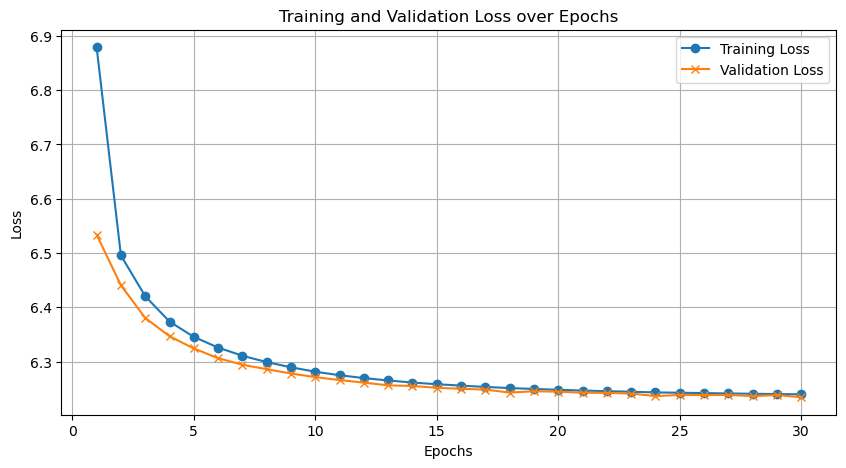

In [3]:
import pickle
import matplotlib.pyplot as plt

tracking_info_path = 'BLIP_checkpoints/train6/tracking_info.pkl'
with open(tracking_info_path, "rb") as f:
    tracking_info = pickle.load(f)

epochs = [info['epoch'] for info in tracking_info]
train_losses = [info['train_loss'] for info in tracking_info]
val_losses = [info['eval_loss'] for info in tracking_info]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()


# Test on an instance

Answer: 0


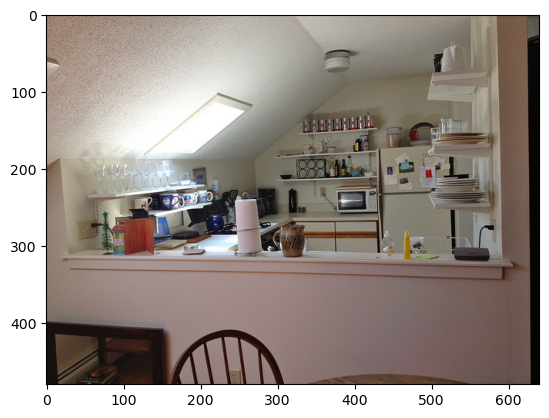

In [4]:
from transformers import BlipForQuestionAnswering, BlipProcessor
from peft import PeftModel
import torch
import matplotlib.pyplot as plt

# Load the base model
base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", cache_dir='BLIP_checkpoints\\')
# Load the LoRA adapters
adapter_model_path = "BLIP_checkpoints\\train6\\best_model"
lora_model = PeftModel.from_pretrained(base_model, adapter_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)

# input
image_path = 'Dataset/val2014/COCO_val2014_000000000164.jpg'
image = plt.imread(image_path)
plt.imshow(image)
question = "how many aluminum cans in the image?"
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Generate an answer
with torch.no_grad():
    output = lora_model.generate(**inputs, max_new_tokens=20)
answer = processor.decode(output[0], skip_special_tokens=True)
print("Answer:", answer)


Answer: tired


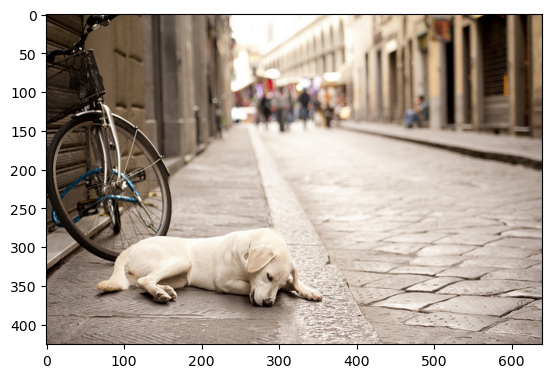

In [5]:
# input
image_path = 'Dataset/val2014/COCO_val2014_000000000074.jpg'
image = plt.imread(image_path)
plt.imshow(image)
question = "how is the dog feeling?"
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Generate an answer
with torch.no_grad():
    output = lora_model.generate(**inputs, max_new_tokens=20)
answer = processor.decode(output[0], skip_special_tokens=True)
print("Answer:", answer)


# Test on VQA benchmark